In [13]:
import numpy as np
import xarray as xr
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable

from glob import glob
from datetime import timedelta as delta
from datetime import datetime

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

from importlib import reload
import plot

In [74]:
reload(plot)

<module 'plot' from '/home/students/4302001/arctic-connectivity/EEZ/plot.py'>

In [48]:
# Load and add velocity field
# readdir = '/Users/daanreijnders/Datasets/'
readdir = '/scratch/DaanR/fields/'
writedir = ''
field_file = 'daily_CESM_0.1degree_controlrun_year_300_arctic_region_timed.nc'

def read_velocity_field(ufiles):
    filenames = {'U': {'lon': ufiles,
                       'lat': ufiles,
                       'data':ufiles},
                 'V': {'lon': ufiles,
                       'lat': ufiles,
                       'data':ufiles}}

    variables = {'U': 'UVEL_5m',
                 'V': 'VVEL_5m'}

    dimensions = {'U': {'time': 'time',
                        'lat': 'ULAT',
                        'lon': 'ULON'},
                  'V': {'time': 'time',
                        'lat': 'ULAT',
                        'lon': 'ULON'}}
    fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation=False)

    fieldset.U.set_scaling_factor(0.01)  #convert cm/s to m/s
    fieldset.V.set_scaling_factor(0.01)
    fieldset.U.vmax = 10;  fieldset.U.vmin = -10;  # set max of flow to 10 m/s
    fieldset.V.vmax = 10; fieldset.V.vmin = -10;
    return fieldset

fieldset = read_velocity_field(readdir+field_file)  

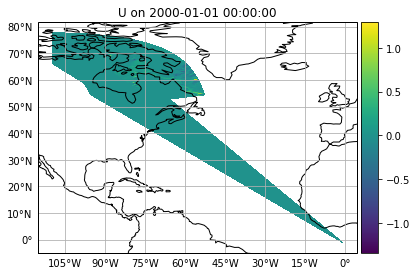

In [49]:
fieldset.U.show()

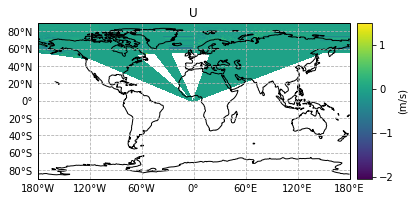

In [75]:
plot.show(fieldset.U, land=False)

In [ ]:
plot.show(fieldset.U, latrange=(60,90), land=False, polar=True)

KeyboardInterrupt: 

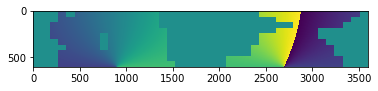

In [52]:
plt.imshow(fieldset.U.grid.lon)

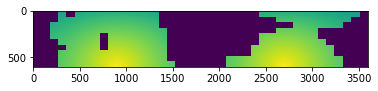

In [47]:
plt.imshow(fieldset.U.grid.lat)

In [58]:
fieldset.U.fieldset

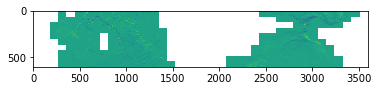

In [76]:
plt.imshow(np.where(fieldset.U.grid.lon==-1, np.NaN, fieldset.U.data)[0])

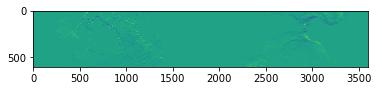

In [77]:
plt.imshow(fieldset.U.data[0,:,:])
plt.show()

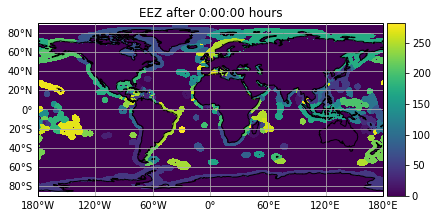

In [78]:
# Load and add EEZ field
EEZ_ds = xr.open_dataset('EEZ_export.nc')
EEZ = EEZ_ds['EEZ'][:,:]
EEZ_lats = EEZ_ds['latitude'].data
EEZ_lons = EEZ_ds['longitude'].data

EEZ_field = Field(name="EEZ", data=EEZ.data[0], mesh='spherical', lon=EEZ_lons, lat=EEZ_lats, allow_time_extrapolation=True)
fieldset.add_field(EEZ_field)

fieldset.EEZ.show()

In [ ]:
dTools.show(fieldset.EEZ)

In [79]:
# Kernels and particleclasses
class myParticle(JITParticle):
        EEZ = Variable('EEZ', dtype=np.int32, to_write=True)

def EEZ_sampler(particle, fieldset, time):
    particle.EEZ = fieldset.EEZ[time, 0., particle.lat, particle.lon]
    
def periodicBC(particle, fieldSet, time):
    if particle.lon > 360.:
        particle.lon -= 360.        
    if particle.lon < 0.:
        particle.lon += 360.  

def OutOfBounds(particle, fieldset, time):
    particle.delete()

In [80]:
def execute_particles(fieldset, \
                      experiment_name='', \
                      npart=10, \
                      runtime=delta(days=200), \
                      dt = delta(minutes=5), \
                      outputdt = delta(hours = 6), \
                      start=(3,75), \
                      finish=(4,76), \
                      show_pset=False):
    if start[0] > 180 or finish[0] > 180:
        raise ValueError("Longitude bounds must be within range (-180,180)")
        
    startLons = np.linspace(start[0], finish[0], npart)
    startLats = np.linspace(start[1], finish[1], npart)
    time = np.array([datetime(2000, 1, 1) for i in range(npart)]) 
    pset = ParticleSet.from_list(fieldset=fieldset, pclass=myParticle, lon=startLons.tolist(), lat=startLats.tolist(), \
                       time = time)
    if show_pset:
        edge = 5 # Degrees around initial distribution
        pset.show()

    kernels = pset.Kernel(AdvectionRK4) # + EEZ_sampler + periodicBC
    pfile = pset.ParticleFile(name = writedir+experiment_name+"_particles", outputdt=outputdt)
    print(f"Run: Advecting {npart} particles for {runtime}")

    pset.execute(kernels, \
                 runtime = runtime, \
                 dt = dt, \
                 output_file = pfile, \
                 recovery = {ErrorCode.ErrorOutOfBounds: OutOfBounds})
    return pset

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pset_loc1 = execute_particles(fieldset, experiment_name='EEZ_loc1', show_pset=True, npart = 100)

In [ ]:
pset_loc2 = execute_particles(fieldset, experiment_name='EEZ_loc4', start=(5,88), finish=(6,88), npart = 100)

In [ ]:
pset_loc3 = execute_particles(fieldset, experiment_name='EEZ_loc3', start=(-60,60), finish=(-59,60), show_pset=True, npart = 100)

In [ ]:
startLons = np.linspace(3, 4, 100)
startLats = np.linspace(74, 75, 100)
time = np.array([datetime(2000, 1, 1) for i in range(100)]) 
pset = ParticleSet.from_list(fieldset=fieldset, pclass=myParticle, lon=startLons.tolist(), lat=startLats.tolist(), \
                   time = time)
pset.show()

In [ ]:
plotTrajectoriesFile('pFileEEZ.nc', mode='movie2d_notebook')

In [ ]:
# Investigate data. Which EEZs are visited?
pfile = xr.open_dataset('pFileEEZ.nc', decode_cf=True)
uniques, counts = np.unique(np.where(np.isnan(pfile['EEZ'].data), -1, pfile['EEZ'].data), return_counts=True)
bardict = dict(zip(uniques, counts))
str(np.ma.filled(pfile.variables['time'], np.nan)[0][0])[:13]

In [ ]:
dTools.animation.EEZ_particles(pfile)

In [ ]:
i = 0
import time
while i < 60:
    i+=1
    time.sleep(60)
    print(i)